# TEAM 24
# Machine Learning Project Code
## Members: Alejandro Garcia, Mukesh Kumar, Selcen Zehra Yokus

# Problem Statement:

Recommendation systems are an important facet of services such as Netflix, Spotify, Youtube, and others. These systems allow a company to provide users with content that they will enjoy without having to search it out themselves.

Our goal is to create a simple recommendation system for Spotify songs. We also test different machine learning algorithms including: KNN, Kmeans, Logistic Regression, and similarity scoring using CosineSimilarity.

# Dataset:

Our dataset is the spotify data provided in class. This data has the reactions of 10 users to various songs. If a user "liked" a song they show this as a 1 while no response is a "0". Note that this is different from an explicit "dislike" since Spotify does not implement "dislikes". User data is divided into 3 files which are stitched together in the code.

There is also a larger song database with 265119 entries. This is divided into 28 files organized by release year of the songs.

Songs in both the user database and the songs are described by 11 features. These are a mix of continuous, discrete, and binary features.

Features are:

Danceability: Continuous.

Energy: Continuous.

Key: Discrete.

Loudness: Continuous.

Mode: Binary.

Speechiness: Continuous.

Acousticness: Continuous.

Instrumentalness: Continuous.

Liveness: Continuous.

Valence: Continuous.

Tempo: Continuous.

Label is:

1 or 0

# Models Used:

The models used in this project are KNN (K-Nearest Neighbor), K-Means, Logistic Regression and Cosine Similarity. All of our models use the Scikit Learn machine learning package for Python.

## KNN

KNN is a form of classification which outputs a label for a test point based on its proximity to a set number (K) of nearest labeled datapoints.

We first feed the model the labeled user data for each user. Each item is described by a set number of features and labeled 1 or 0. The songs data is then fed into the model and a predicted label is output.

The number of neighbors used is determined by testing the accuracy of the model as a function of K for each user. We saw from the output that K values past 3 do not seem to have a significant effect on model accuracy. We chose to then go with K = 10 seems it seemed effective for all users.

## KMeans

KMeans attempts to cluster data by first setting K centroids randomly throughout model space. The position of these centroids is then recomputed by assigning labeled data points to the closest centroid (to the data point itself) and then finding the average position of all associated data points which is then the new location of the centroid. Effectively it runs like this:

1. Random initial centroid position.
2. Labeled points assigned to centroid based on distance.
3. New position for centroid calculated based on average of associated data points.
4. Labeled points assigned to centroid based on distance.
5. etc........

Until the position of the centroid stops changing or some set number of iterations is reached.

Similar to KNN we first feed the model labeled data and then output a prediction after feeding it unlabeled data.

Testing various values of K seems to show that anything past K = 2 only worsens results.

## Cosine Similarity

Cosine Similarity returns a similarity score (between 0 and 1) for a pair of items. In this case we use Cosine Similarity to obtain the similarity of songs in the larger database to songs in the user database. We then order songs based on the number of times a certain similarity threshold was reached with respect to the user song. For example:

If we have song A in the songs database and songs B,C,D, and E in the user data. We can obtain a list of similarities:

A-B: 0.75

A-C: 0.8

A-D: 0.4

A-E: 0.9

We set a cutoff value, in this examples maybe 0.8, and give A 2 points since it matches or exceeds that value 2 times. We can then order songs based off this count/point system so that songs that tend to be similiar to user songs most often are recommended first. Following the example, if we have a new song F that we want to check:

F-B: 0.45

F-C: 0.95

F-D: 0.50

F-E: 0.60

We would then give F 1 point since it surpassed the threshold of 0.8 one time. In this case we can recommend songs to the user in the order A (2 points), F(1 point).

## Logistic Regression

Logistic Regression works by setting a decision boundary within feature space. The position of items in feature space with regards to this decision boundary is what then allow us to assign a label to that item. In this case we are dealing with a binary decision, either 1 or 0.

# Analysis and Results

Splitting our user data into testing and training sets allowed us to verify model reliability.

# Conclusions and Insights

## 1 : Import necessary packages and modules and misc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import seaborn as sns
import pandas as pd
import sklearn.metrics
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import collections

# # Custom Color Palette
#green_red = ['#58D68D','#EF4846']
#palette = sns.color_palette(green_red)
#sns.set_palette(palette)
#sns.set_style("white")

## 2 : Define classes for project.

In this case we have two classes: musicFan() and songs(). musicFan() is intanced using data from each user while songs() takes in the entirety of the larger song database.

musicFan() has mutiples associated methods for analyzing the data:

getFromData(self,dataBase):
    This pulls additional data from the database file, namely the song names for songs in the user files.

mean(self):
    This gets the mean of each feature for each user as well as the median and the percentage of 1 vs. 0.
    
makeScatters(self,songs):
    This creates scatter plots of all combinations of features (11 features gives 55 unique combinations in total). This then saves the graphs as .png in an output folder called UserOutput/. Blue points are songs liked by user while red points are randomly sampled songs from the larger songs database.
        
makeHistos(self,songs):
    This creates histograms for each feature for each user and plots both like (1) vs. no like (0). Also capable of plotting for entire songs database.

cosineSimilarity(self,songs,outputRec = False):
    This runs the cosine similarity model (described below) and outputs a recommendation for each user.


    

In [2]:
class musicFan:
    
    keys = np.array(["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness"\
            ,"liveness","valence","tempo"])
    indices = [0,1,2,3,4,5,6,7,8,9,10]
    
    def __init__(self,ID,tastes):
        
        self.ID = ID
        self.session = np.int_(tastes[11])
        self.dataID = np.array(tastes[13],dtype = "str")
        #self.songID = tastes[14] #this has issues right now, always use dataID
        self.response = np.int_(tastes[12]) == 1 #Mask array of True or False where True is like and False is no like.
        self.tastes = np.array([np.float64(tastes[0]), np.float64(tastes[1]), np.int_(tastes[2])\
                       , np.float64(tastes[3]), np.int_(tastes[4]), np.float64(tastes[5]),\
                       np.float64(tastes[6]), np.float64(tastes[7]), np.float64(tastes[8])\
                       , np.float64(tastes[9]), np.float64(tastes[10])]).T
        self.songNames = []
        self.simSongsNames = []
        self.simSongsID = []
        self.fMask = [True,True,True,True,False,True,True,False,True,False,True]
        #Discarded features: Valence,Instrumentalness
        #self.fMask = [True,True,True,True,True,True,True,True,True,True,True]
        
        print("CREATING musicFan INSTANCE FOR USER:",self.ID,"WITH ITEMxFEATURE MATRIX OF SHAPE:",self.tastes.shape)
        print("*----------------------------------------------------*")
        
        if not os.path.exists("UserOutput"):
            os.makedirs("UserOutput")
        if not os.path.exists("UserOutput/User"+str(self.ID)):
            os.makedirs("UserOutput/User"+str(self.ID))
        
        
    def getFromData(self,dataBase):
        print("GETTING ADDITONAL DATA FROM DB FILE FOR USER:",self.ID)
        print("*----------------------------------------------------*")
        self.songNames = []
        songNames = np.array(dataBase["song_name"])
        dID = np.array(dataBase["database_id"])
        for i in range(len(self.dataID)):
            for x in range(len(songNames)):
                if dID[x] in self.dataID[i]:
                    self.songNames.append(songNames[x])
        self.songNames = np.array(self.songNames)

        
    def mean(self):
        self.mean_Tastes = np.mean(self.tastes, axis = 1)
        self.median_Tastes = np.median(self.tastes, axis = 1)
        self.percent_Positive = np.mean(self.response)
        print("For musicFan "+str(self.ID)+" the mean values are:\n",self.mean_Tastes,"\n","The median values are:\n"\
              ,self.median_Tastes,"\n","Percent positive: " +str(self.percent_Positive)+"\n")
        #return self.mean_Tastes

    def makeScatters(self,songs):
        num_Comb = 55
        
        if not os.path.exists("UserOutput/User"+str(self.ID)+"/scatters"):
            os.makedirs("UserOutput/User"+str(self.ID)+"/scatters")
        
        combinations = []
        
        for i in self.indices:
            for j in self.indices:
                if [i,j] not in combinations and [j,i] not in combinations and i != j:
                    combinations.append([i,j])
        for i in combinations:
            fig1, ax1 = plt.subplots()
            ax1.scatter(songs.features[:,i[0]][::500],songs.features[:,i[1]][::500], color = "red")
            ax1.scatter(self.tastes[:,i[0]][self.response==1],self.tastes[:,i[1]][self.response==1], color = "blue")
            ax1.set_xlabel(self.keys[i[0]])
            ax1.set_ylabel(self.keys[i[1]])
            ax1.set_title(self.keys[i[0]]+"vs."+self.keys[i[1]])
            plt.savefig("UserOutput/User"+str(self.ID)+"/scatters/"+self.keys[i[0]]+"_"+self.keys[i[1]]+".png")
            plt.close("all")
            
        print(combinations)
        print(len(combinations))
        
    def makeHistos(self,songs):
        
        if not os.path.exists("UserOutput/User"+str(self.ID)+"/histograms"):
            os.makedirs("UserOutput/User"+str(self.ID)+"/histograms")
        
        for i in self.indices:
            fig1, ax1 = plt.subplots()
            ax1.grid(linestyle="--")
            #ax1.hist(songs.features[:,i], bins = 20, color = "black",density=True,histtype = "step")#all songs
            ax1.hist(self.tastes[:,i][self.response==0], bins = 20, color = "red",density=True,histtype = "step",label="0",linewidth=2.0)#song with no like
            ax1.hist(self.tastes[:,i][self.response==1], bins = 20, color = "blue",density=True,histtype = "step",label="1",linewidth=2.0)#songs liked
            ax1.set_xlabel(self.keys[i])
            ax1.set_ylabel("normalized count")
            ax1.set_title("Histogram of "+self.keys[i]+" for User: "+str(self.ID))
            ax1.legend()
            plt.savefig("UserOutput/User"+str(self.ID)+"/histograms/"+self.keys[i]+"_histogram"+".png")
            plt.close("all")
            
    def cosineSimilarity(self,songs,outputRec = False):
        print("INITIATING COSINE SIMILARITY BASED RECOMMENDATION FOR USER: ", self.ID)
        print("*----------------------------------------------------*")
        a = sklearn.preprocessing.normalize(self.tastes[:,self.fMask][self.response == 1],axis=0)
        print(self.tastes[:,self.fMask][self.response == 1].shape)
        b = sklearn.preprocessing.normalize(songs.features[:,self.fMask],axis=0)
        print(songs.features[:,self.fMask].shape)
        cSim = sklearn.metrics.pairwise.cosine_similarity(a,b)
        self.simSongsNames = np.array([songs.name[i>0.95] for i in cSim])
        self.simSongsID = np.array([songs.ID[i>0.95] for i in cSim])
        if outputRec:
            a = np.concatenate([songs.ID[cSim[i]>0.95] for i in range(len(cSim))])
            b = collections.Counter(a).most_common() #returns a count of values        
            print("Recommended songs for user:",self.ID,".")
            print("ID",b[0:10])
            #return b
        print("Cosinesimilarity successful for user:",self.ID,".")
        print("*----------------------------------------------------*")

    def KNN(self,songs,outputRec=False):
        n = 10 #number of neighbors
        print("INITIATING KNN RECOMMENDATION FOR USER: ", self.ID, "USING:",n,"NEIGHBORS.")
        print("*----------------------------------------------------*")
        X_train = sklearn.preprocessing.normalize(self.tastes,axis=0)
        X_test = sklearn.preprocessing.normalize(songs.features,axis=0)
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train[:,self.fMask],self.response)
        y_Pred = knn.predict(X_test[:,self.fMask])
        if outputRec:
            print("Recommended songs for user:",self.ID,".")
            print(y_Pred.sum(),": Num of songs predicted.")
            print(songs.name[y_Pred])
        print("*----------------------------------------------------*")
    
    def train_Test(userList,cSim=False,KNN=False,logistic=False,KM=False):
        print("INITIATING MODEL TESTING")
        print("*----------------------------------------------------*")
        if cSim:
            print("For a user, i, the chance of cosineSimilarity recommendation being better than random song picks is:\n")
            for i in userList:
                plus = 0
                size = 0
                for y in range(100):
                    X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=y)
                    a = sklearn.preprocessing.normalize(X_train[:,i.fMask][y_train == 1],axis=0)
                    b = sklearn.preprocessing.normalize(X_test[:,i.fMask],axis=0)
                    labels = np.array([str(x) for x in range(len(b))])
                    cSim = sklearn.metrics.pairwise.cosine_similarity(a,b)
                    c = np.concatenate([labels[cSim[x]>0.985] for x in range(len(cSim))])
                    d = collections.Counter(c).most_common() #returns a count of values
                    if y_test[[int(x[0]) for x in d[0:10]]].sum()/len(y_test[[int(x[0]) for x in d[0:10]]]) > y_test.sum()/len(y_test):
                        plus = plus+1
                        size = size + len(y_test[[int(x[0]) for x in d[0:10]]])
                print("For:",i.ID,":",plus/(y+1))
        if KNN:
            print("For a user, i, the average accuracy of KNN recommendation is:\n")
            for i in userList:
                K = []
                Acc = []
                X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=0)
                X_train = sklearn.preprocessing.normalize(X_train,axis=0)
                X_test = sklearn.preprocessing.normalize(X_test,axis=0)
                for w in range(10):
                    knn = KNeighborsClassifier(n_neighbors=w+1)
                    knn.fit(X_train[:,i.fMask], y_train)
                    y_Pred = knn.predict(X_test[:,i.fMask])
                    Acc.append(sklearn.metrics.accuracy_score(y_test,y_Pred))
                    K.append(w+1)
                plt.plot(K, Acc,"--", label="User:"+str(i.ID+1))
                
                acc = 0
                for y in range(100):
                    X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=y)
                    X_train = sklearn.preprocessing.normalize(X_train,axis=0)
                    X_test = sklearn.preprocessing.normalize(X_test,axis=0)
                    knn = KNeighborsClassifier(n_neighbors=10)
                    knn.fit(X_train[:,i.fMask], y_train)
                    y_Pred = knn.predict(X_test[:,i.fMask])
                    acc = acc + sklearn.metrics.accuracy_score(y_test,y_Pred)
                print("For:",i.ID,":",acc/(y+1))
            print("Plot of accuracy vs. K for KNN model for each user")
            plt.ylabel("Accuracy")
            plt.xlabel("K")
            plt.legend()
            plt.show()
                
        if logistic:
            print("For a user, i, the average accuracy of logistic regression recommendation is:\n")
            for i in userList:
                acc = 0
                for y in range(100):
                    X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=y)
                    X_train = sklearn.preprocessing.normalize(X_train,axis=0)
                    X_test = sklearn.preprocessing.normalize(X_test,axis=0)
                    logReg = LogisticRegression(solver='lbfgs')
                    logReg.fit(X_train[:,i.fMask], y_train)
                    y_Pred = logReg.predict(X_test[:,i.fMask])
                    acc = acc + sklearn.metrics.accuracy_score(y_test,y_Pred)
                print("For:",i.ID,":",acc/(y+1))
        if KM:
            print("For a user, i, the average accuracy of Kmeans recommendation is:\n")
            for i in userList:
                K = []
                Acc = []
                X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=0)
                X_train = sklearn.preprocessing.normalize(X_train,axis=0)
                X_test = sklearn.preprocessing.normalize(X_test,axis=0)
                for w in range(20):
                    kMeans = KMeans(n_clusters = w+1)
                    kMeans.fit(X_train[:,i.fMask], y_train)
                    y_Pred = kMeans.predict(X_test[:,i.fMask])
                    Acc.append(sklearn.metrics.accuracy_score(y_test,y_Pred))
                    K.append(w+1)
                plt.plot(K, Acc,"o", label="User:"+str(i.ID+1))
                
                acc = 0
                for y in range(10):
                    X_train, X_test, y_train, y_test = train_test_split(i.tastes,i.response,test_size = 0.3, random_state=y)
                    X_train = sklearn.preprocessing.normalize(X_train,axis=0)
                    X_test = sklearn.preprocessing.normalize(X_test,axis=0)
                    kMeans = KMeans(n_clusters = 2)
                    kMeans.fit(X_train[:,i.fMask], y_train)
                    y_Pred = kMeans.predict(X_test[:,i.fMask])
                    acc = acc + sklearn.metrics.accuracy_score(y_test,y_Pred)
                print("For:",i.ID,":",acc/(y+1))
            print("Plot of accuracy vs. K for KMeans model for each user")
            plt.ylabel("Accuracy")
            plt.xlabel("K")
            plt.legend()
            plt.show()
                
        print("*----------------------------------------------------*")
        print("MODEL TESTING COMPLETE")

In [3]:
class songs:

    keys = ["danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness"\
            ,"liveness","valence","tempo"]
    
    def __init__(self,features):
        
        self.ID = features[:,18]
        self.name = features[:,19]
        self.albumID = features[:,2]
        self.albumName = features[:,3]
        self.artistID = features[:,5]
        self.artistName = features[:,6]
        self.year = features[:,26]
        self.features = np.array([np.float64(features[:,7]), np.float64(features[:,10]), np.float64(features[:,12]), np.float64(features[:,14]),\
                                    np.int_(features[:,15]), np.float64(features[:,20]), np.float64(features[:,1]),\
                                    np.float64(features[:,11]),np.float64(features[:,13]),np.float64(features[:,25]),np.float64(features[:,21])]).T
        
        print("CREATING songs INSTANCE WITH ITEMxFEATURE MATRIX OF SHAPE:",self.features.shape)
        print("*----------------------------------------------------*")

## 3 : Load files

In [4]:
#setting the working directory to file location
#if you want to run this yourself make sure this is the directory that holds both user_data/ and music_data/
filepath = "C:\\Users\\agarc\\Documents\\GitHub\\Projects\\Spotify"
os.chdir(filepath)

## Showing file list:

Below we print all files in the user_data/ and music_data/ directories.

User data is stored in 3 files: alpha50.csv, alpha75.csv, and alpha100.csv. In addition there is a database.csv file which includes some additional, albeit optional, information on the songs referenced in the alpha files.
    
Song data is stored in 28 files organized based on the year the song came out: 1991.csv, 1992.csv, ......., 2018.csv.
    

In [5]:
user_Filenames = os.listdir("user_data")
print("The list of files in user_data/ is:\n")
print(user_Filenames,"\n")
print("The list of files in music_data/ is:\n")
music_Filenames = os.listdir("music_data")
print(music_Filenames,"\n")

The list of files in user_data/ is:

['.DS_Store', '.ipynb_checkpoints', 'alpha100.csv', 'alpha50.csv', 'alpha75.csv', 'database.csv'] 

The list of files in music_data/ is:

['1991.csv', '1992.csv', '1993.csv', '1994.csv', '1995.csv', '1996.csv', '1997.csv', '1998.csv', '1999.csv', '2000.csv', '2001.csv', '2002.csv', '2003.csv', '2004.csv', '2005.csv', '2006.csv', '2007.csv', '2008.csv', '2009.csv', '2010.csv', '2011.csv', '2012.csv', '2013.csv', '2014.csv', '2015.csv', '2016.csv', '2017.csv', '2018.csv'] 



In [6]:
#opening all user data and music data
print("LOADING FILES")
print("*----------------------------------------------------*")

#----------------------------------------------------------------------------------------------------#
data_Base = pd.read_csv("user_data/database.csv",delimiter = ",", dtype = "str")
#----------------------------------------------------------------------------------------------------#
user_Files = [pd.read_csv("user_data/"+i,delimiter = ",", dtype = "str") for i in user_Filenames if "alpha" in i]
for i in range(len(user_Files)):
    user_Files[i]["spotify_id"] = data_Base["spotify_id"][data_Base["database_id"].isin(user_Files[i]["database_id"])]

df_user_songs = pd.concat(user_Files)
user_Data = df_user_songs.values
#----------------------------------------------------------------------------------------------------#
music_Files = [pd.read_csv("music_data/"+i,delimiter = ",", dtype = "str") for i in music_Filenames]
for i in range(len(music_Files)):
    music_Files[i]["year"] = music_Filenames[i][:-4]

song_list = pd.concat(music_Files)
music_Data = song_list.values
#----------------------------------------------------------------------------------------------------#

LOADING FILES
*----------------------------------------------------*


## 4 : Exploratory Data Analysis (EDA)

EDA is an important first step in analyzing data.

Here we start by showing the data for both users and songs as a pandas dataframe header output. We then use seaborn's pairplot method in order to plot the distributions of each feature and the 

In [7]:
#Print the user data. This data is from the 3 user files which
#have been stitched together. We can see the 11 main features as well as userID for each user.
df_user_songs.head(4)

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,user_session,user_response,user_id,database_id,spotify_id
0,0,0.374,0.85,4,-5.657,0,0.0404,0.0904,0.0,0.116,0.348,125.796,1,0,0,5bb7ac930c27ee4c381dd9dc,0bxllxzqkGNSKo8pHtZyA3
1,1,0.505,0.366,5,-9.197,1,0.025,0.353,1.39e-05,0.124,0.115,100.533,1,0,0,5bb7ac960c27ee4c381dda8b,362LzQDbfNdZDuv37BIEkG
2,2,0.674,0.943,0,-3.413,1,0.0408,0.0159,0.0,0.504,0.856,118.06,1,1,0,5bb7ac910c27ee4c381dd91b,3AqPL1n1wKc5DVFFnYuJhp
3,3,0.602,0.746,0,-3.528,1,0.0365,0.186,0.0,0.122,0.617,118.026,1,0,0,5bb7ac8e0c27ee4c381dd843,7sDzAu7alAL1hWvL86tSGB


In [8]:
#The database file has extra information, namely song name and spotify id. Songs are linked between the user file and the
#database file by the database id parameter.
data_Base.head(2)

,database_id,spotify_id,song_name,preview_url,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,5bb7ac890c27ee4c381dd69e,0bxllxzqkGNSKo8pHtZyA3,E.T.,https://p.scdn.co/mp3-preview/b010313e8fbd71b1...,0.626,0.457,8,-9.091,0,0.0339,0.0876,7.72E-05,0.0801,0.223,149.99
1,5bb7ac890c27ee4c381dd69f,362LzQDbfNdZDuv37BIEkG,Song For Zula - Live From Spotify London,https://p.scdn.co/mp3-preview/f85a3283dc9d614c...,0.441,0.344,4,-9.799,1,0.0299,0.386,0.000277,0.917,0.111,87.588


In [9]:
#Here we print the 11 features for a single user, the one who's id matches 0.
df_0=df_user_songs[df_user_songs['user_id'] == "0"]
print('For User0:')
df_0.iloc[:,1:12].head(2)

For User0:


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.374,0.85,4,-5.657,0,0.0404,0.0904,0.0,0.116,0.348,125.796
1,0.505,0.366,5,-9.197,1,0.025,0.353,1.39e-05,0.124,0.115,100.533


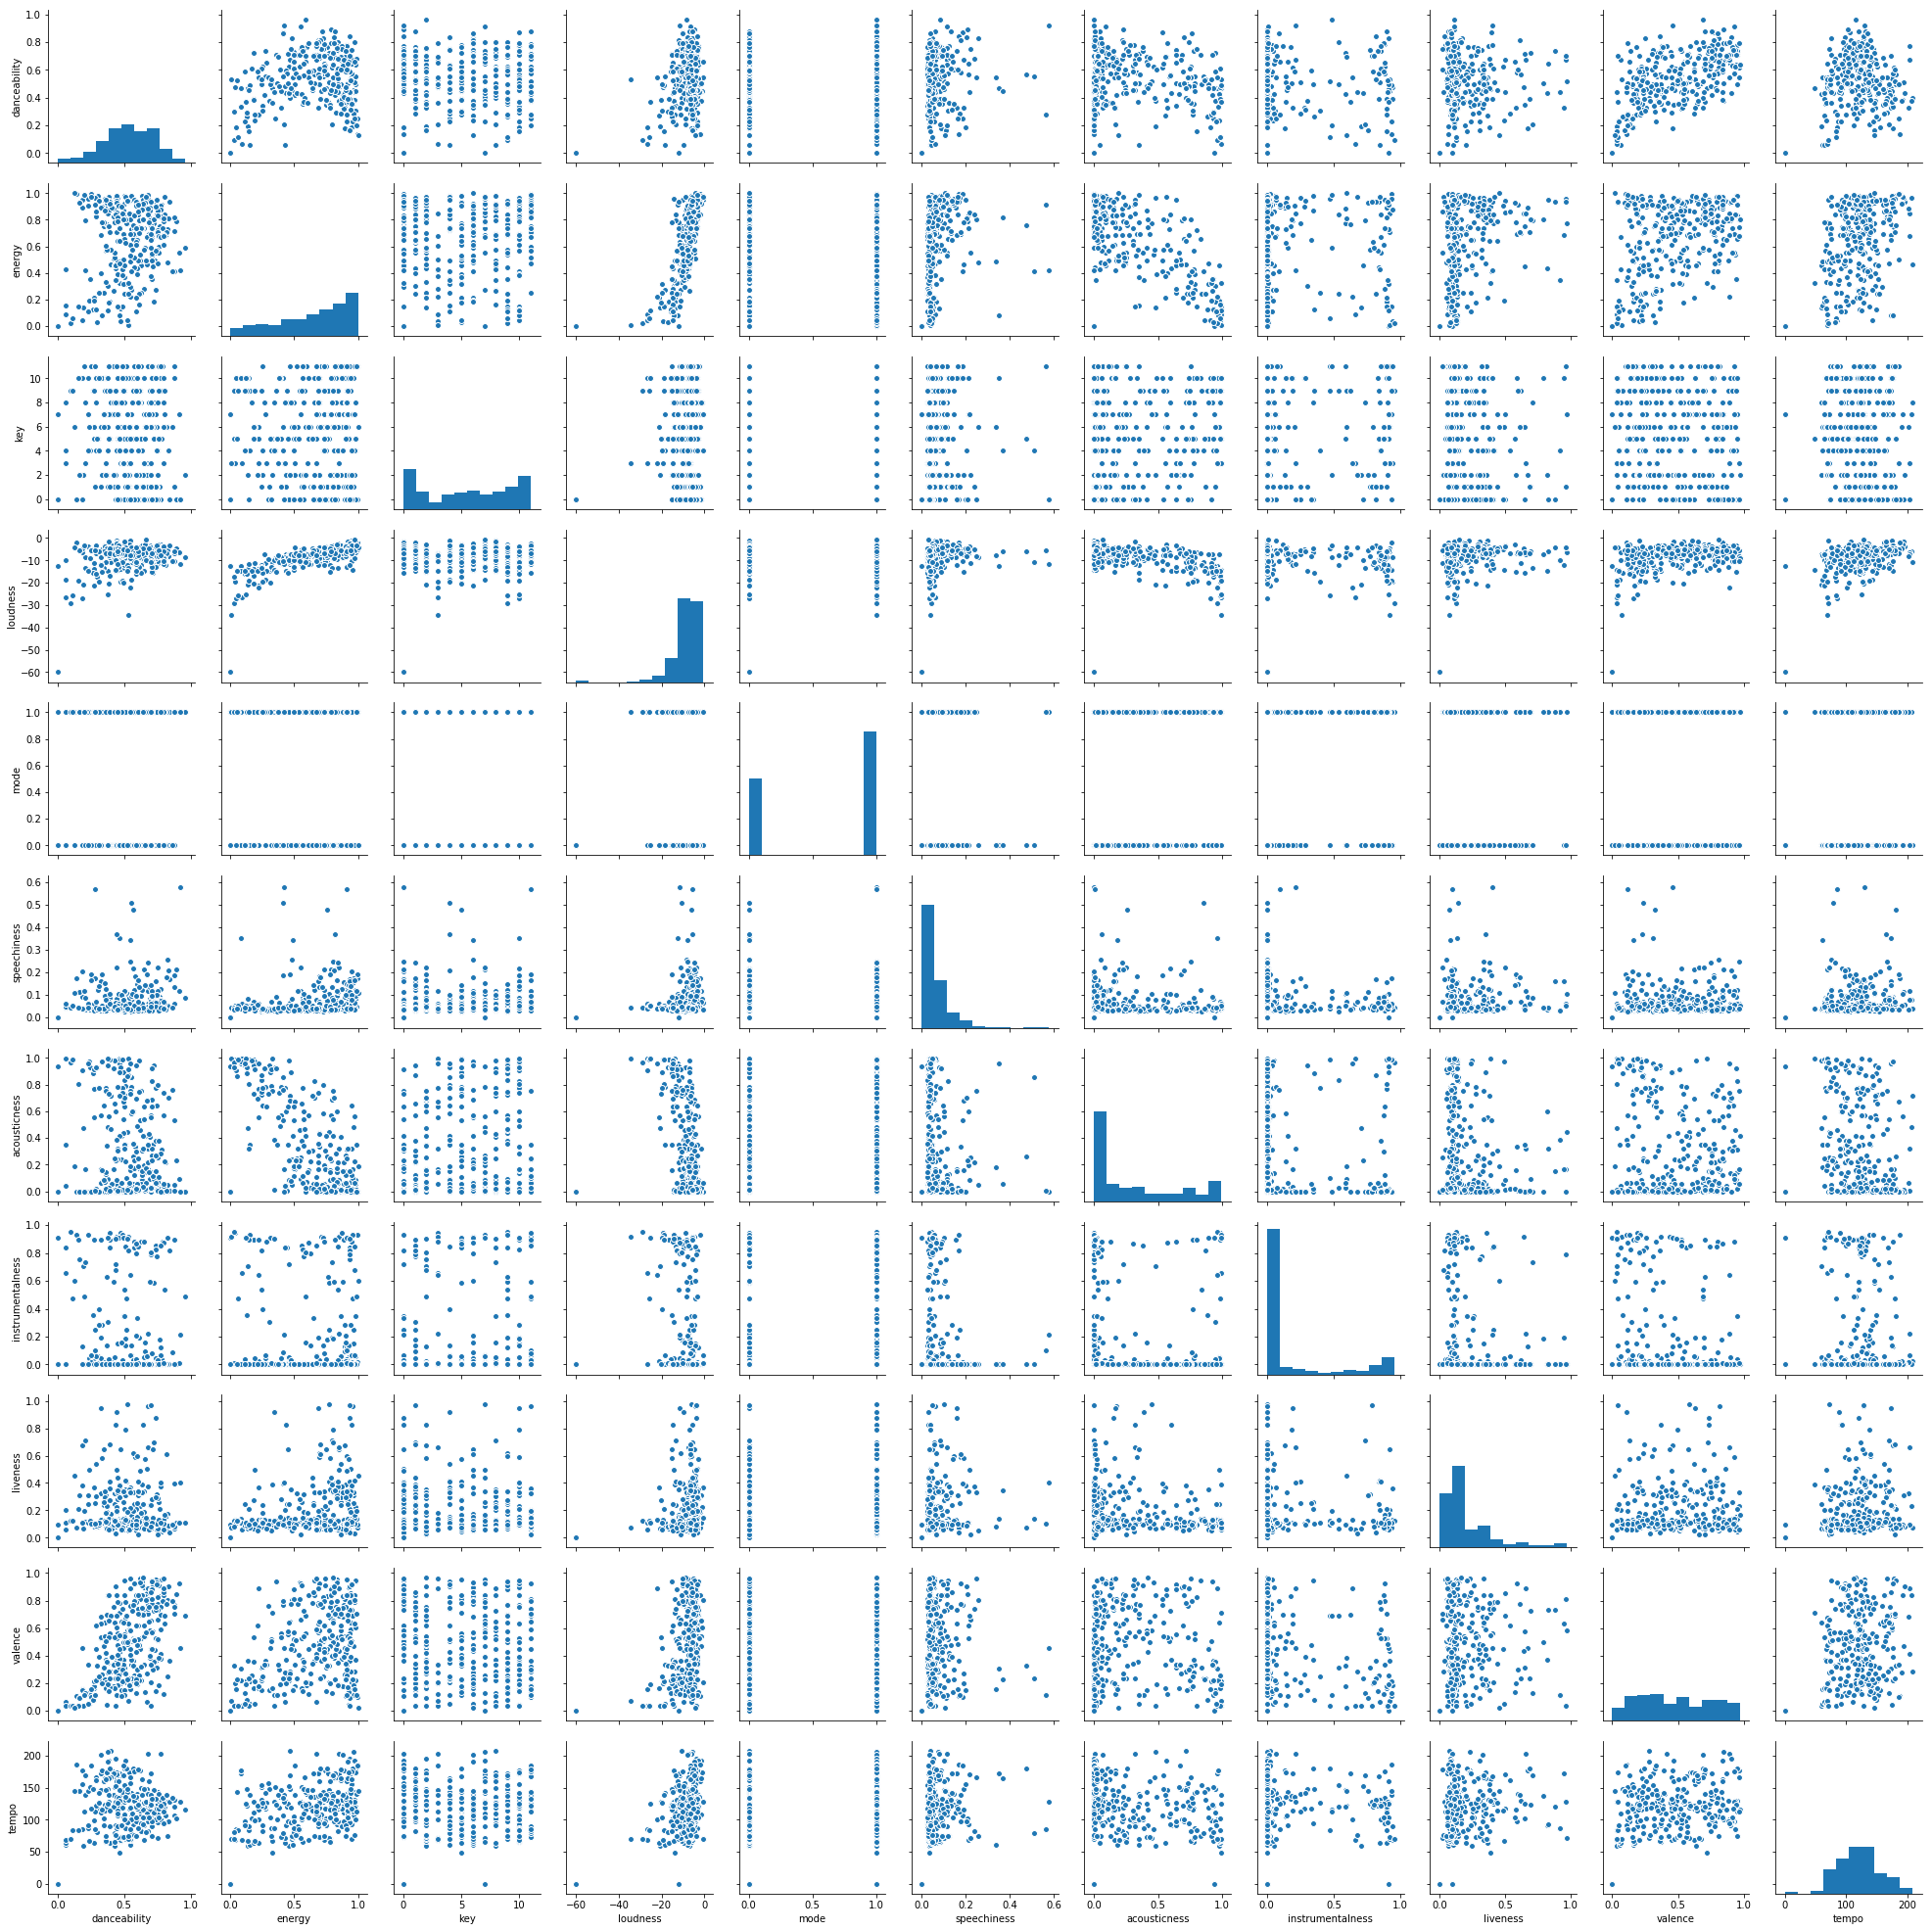

In [10]:
#Pairplot allows quick and easy plotting of all combinations of features as well as showing the distributions
#of a single feature (diagonal)
sns.pairplot(df_0.iloc[:,1:12].astype(float))

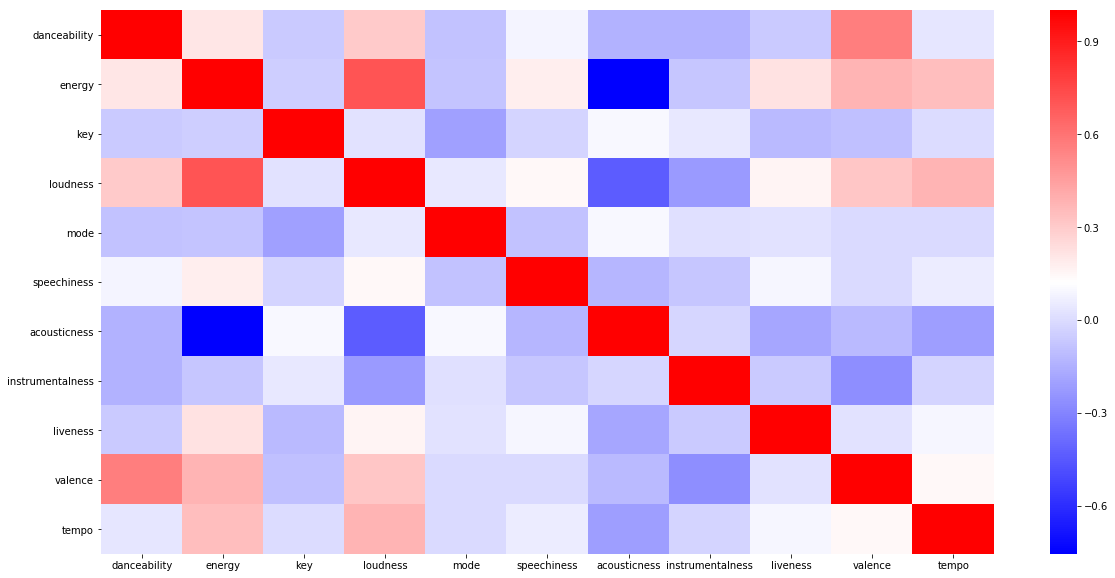

In [11]:
#The following is a correlation heatmap for user0. Correlations can be positive (red) or negative (blue)
plt.figure(figsize=(20,10))
sns.heatmap(df_0.iloc[:,1:12].astype(float).corr(),cmap="bwr")

In [12]:
#We can print the heatmap data as a table see a strong correlation between the following pairs where corr > 0.4:
# Postive : Energy and Loudness
#         : Valence and Danceability
# Negative: Energy and Acousticness
#         : Loudness and Acousticness
#defining a color function
def color_text(val):
    if val>=0.6:
        color = 'green'
    elif val>=0.3:
        color = 'blue'
    elif val<0.3 and val>-0.3:
        color = 'red'
    elif val<=-0.3:
        color = 'black'
    elif val<=-0.6:
        color = 'yellow'
    
    return 'color: %s' % color

#User 0
#print(df_0)
#df_0.style.applymap(color, subset=df_0.iloc[:,0:11].corr())
df_0.iloc[:,1:12].astype(float).corr().style.applymap(color_text)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
danceability,1,0.211557,-0.0584562,0.305198,-0.084649,0.0852482,-0.142921,-0.138279,-0.0621934,0.566541,0.0383888
energy,0.211557,1,-0.0429283,0.708325,-0.0804431,0.181979,-0.755012,-0.07595,0.223279,0.378359,0.344592
key,-0.0584562,-0.0429283,1,0.0210284,-0.202922,-0.0222255,0.0987679,0.0449649,-0.115309,-0.0955393,0.00236884
loudness,0.305198,0.708325,0.0210284,1,0.045692,0.148998,-0.432976,-0.226622,0.160574,0.320838,0.378754
mode,-0.084649,-0.0804431,-0.202922,0.045692,1,-0.0844414,0.0957524,0.0166349,0.0210834,-0.00192596,-0.00649031
speechiness,0.0852482,0.181979,-0.0222255,0.148998,-0.0844414,1,-0.127181,-0.0708963,0.091595,-0.00202235,0.060701
acousticness,-0.142921,-0.755012,0.0987679,-0.432976,0.0957524,-0.127181,1,-0.0159912,-0.18258,-0.116552,-0.212434
instrumentalness,-0.138279,-0.07595,0.0449649,-0.226622,0.0166349,-0.0708963,-0.0159912,1,-0.0593834,-0.267147,-0.02266
liveness,-0.0621934,0.223279,-0.115309,0.160574,0.0210834,0.091595,-0.18258,-0.0593834,1,0.0258024,0.0900532
valence,0.566541,0.378359,-0.0955393,0.320838,-0.00192596,-0.00202235,-0.116552,-0.267147,0.0258024,1,0.145462


In [13]:
#Here we print out the larger songs database which includes several more columns
#than the user data. In particular it has info on artists and albums.
song_list.iloc[:,1:20].head(2)

,acousticness,album_id,album_name,analysis_url,artist_ids,artist_names,danceability,disc_number,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,popularity,preview_url,song_id,song_name
0,0.108,67nqYhvjDyJXGD64937Lw3,The Beach Boys' Christmas Album,https://api.spotify.com/v1/audio-analysis/5xlS...,"3oDbviiivRWhXwIE8hxkVV,03IJEZ6IynYczgge2uC4YD,...","The Beach Boys,Mark Linett,Sweet,Larry Walsh",0.602,1,118840,0.553,0.0,11,0.0512,-9.336,1,72,NaN,5xlS0QkVrSH7ssEbBgBzbM,Little Saint Nick - 1991 Remix
1,0.425,4S2ZR5njbJez1rV8DV5Vtl,Live In Japan,https://api.spotify.com/v1/audio-analysis/4gdh...,7FIoB5PHdrMZVC3q2HE5MS,George Harrison,0.611,2,211320,0.566,0.000954,9,0.878,-11.715,1,62,NaN,4gdhsYfXJoVQsWpbmh32Da,Here Comes The Sun - Live In Japan/1991/Remast...


## 5 : Create user and song instances

In [14]:
#initializing a set of user objects based on the musicFan class
m_Fans = []
songs = songs(music_Data[np.isfinite(np.float64(music_Data[:,7]))])

CREATING songs INSTANCE WITH ITEMxFEATURE MATRIX OF SHAPE: (265119, 11)
*----------------------------------------------------*


In [15]:
#This loop creates a list of m_Fan objects.
for i in range(10):
    temp = [[user_Data[x][y+1] for x in range(len(user_Data)) if i == int(user_Data[x][14])] for y in range(16) if y !=13]
    m_Fans.append(musicFan(i,temp))
    #m_Fans[i].makeScatters(songs)
    #m_Fans[i].makeHistos(songs)

CREATING musicFan INSTANCE FOR USER: 0 WITH ITEMxFEATURE MATRIX OF SHAPE: (338, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 1 WITH ITEMxFEATURE MATRIX OF SHAPE: (393, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 2 WITH ITEMxFEATURE MATRIX OF SHAPE: (410, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 3 WITH ITEMxFEATURE MATRIX OF SHAPE: (461, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 4 WITH ITEMxFEATURE MATRIX OF SHAPE: (514, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 5 WITH ITEMxFEATURE MATRIX OF SHAPE: (443, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE FOR USER: 6 WITH ITEMxFEATURE MATRIX OF SHAPE: (331, 11)
*----------------------------------------------------*
CREATING musicFan INSTANCE 

In [16]:
for i in range(10):
    m_Fans[i].getFromData(data_Base)

GETTING ADDITONAL DATA FROM DB FILE FOR USER: 0
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 1
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 2
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 3
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 4
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 5
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 6
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 7
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 8
*----------------------------------------------------*
GETTING ADDITONAL DATA FROM DB FILE FOR USER: 9
*------------------------

## 5 : Training and testing various models: cSim, KNN, Logistic Regression, KMeans

INITIATING MODEL TESTING
*----------------------------------------------------*
For a user, i, the chance of cosineSimilarity recommendation being better than random song picks is:

For: 0 : 0.67
For: 1 : 0.57
For: 2 : 0.77
For: 3 : 0.82
For: 4 : 0.41
For: 5 : 0.86
For: 6 : 0.57
For: 7 : 0.51
For: 8 : 0.48
For: 9 : 0.98
*----------------------------------------------------*
MODEL TESTING COMPLETE
INITIATING MODEL TESTING
*----------------------------------------------------*
For a user, i, the average accuracy of KNN recommendation is:

For: 0 : 0.6609803921568627
For: 1 : 0.5552542372881356
For: 2 : 0.709186991869919
For: 3 : 0.8155395683453235
For: 4 : 0.7879999999999999
For: 5 : 0.585488721804511
For: 6 : 0.7385000000000003
For: 7 : 0.5862962962962964
For: 8 : 0.510925925925926
For: 9 : 0.7268695652173913
Plot of accuracy vs. K for KNN model for each user


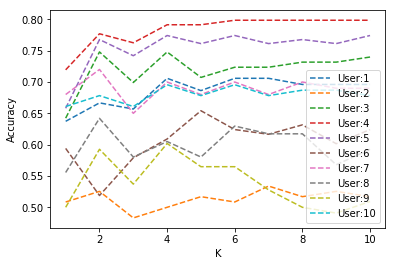

*----------------------------------------------------*
MODEL TESTING COMPLETE
INITIATING MODEL TESTING
*----------------------------------------------------*
For a user, i, the average accuracy of logistic regression recommendation is:

For: 0 : 0.678529411764706
For: 1 : 0.5804237288135593
For: 2 : 0.7234146341463417
For: 3 : 0.8199999999999993
For: 4 : 0.7897419354838712
For: 5 : 0.5944360902255641
For: 6 : 0.7407999999999997
For: 7 : 0.5967901234567902
For: 8 : 0.5402777777777782
For: 9 : 0.7296521739130436
*----------------------------------------------------*
MODEL TESTING COMPLETE
INITIATING MODEL TESTING
*----------------------------------------------------*
For a user, i, the average accuracy of Kmeans recommendation is:

For: 0 : 0.5049019607843138
For: 1 : 0.49491525423728805
For: 2 : 0.5260162601626016
For: 3 : 0.5100719424460431
For: 4 : 0.5309677419354839
For: 5 : 0.48270676691729325
For: 6 : 0.526
For: 7 : 0.5111111111111111
For: 8 : 0.4851851851851852
For: 9 : 0.52173913

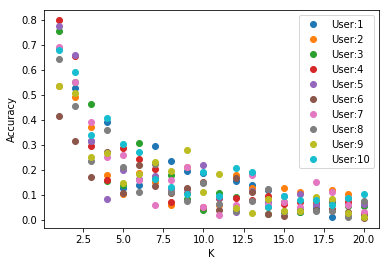

*----------------------------------------------------*
MODEL TESTING COMPLETE


In [17]:
#this test the models for each user.
musicFan.train_Test(m_Fans,cSim=True)
musicFan.train_Test(m_Fans,KNN=True)
musicFan.train_Test(m_Fans,logistic=True)
musicFan.train_Test(m_Fans,KM=True)

In [18]:
#running cSim model and outputting recommendation:
for i in range(10):
    m_Fans[i].cosineSimilarity(songs,outputRec=True)
    m_Fans[i].KNN(songs,outputRec=True)

INITIATING COSINE SIMILARITY BASED RECOMMENDATION FOR USER:  0
*----------------------------------------------------*
(109, 8)
(265119, 8)
Recommended songs for user: 0 .
ID [('7qKJrEYAO22JNHSrgK43lg', 63), ('6CAdgnhKyJYtpJiVxTdDfT', 63), ('1XzeGTpwZPefPTI81Fde4B', 60), ('7D5qCBnl1Qab2qndKHXcLG', 60), ('7KWRfJkrBghJDSphN1taut', 60), ('2Gyuge3kQa0KBJ5EsMhYNJ', 57), ('4HO9PDJLT2j2vRsIkkIPur', 57), ('2ZApTsveC0XnZDPfpOgnx6', 54), ('7AARXbifhQ0g7DdUxDsvON', 54), ('2Qi2RbXilMTewXIu6QFamP', 54)]
Cosinesimilarity successful for user: 0 .
*----------------------------------------------------*
INITIATING KNN RECOMMENDATION FOR USER:  0 USING: 10 NEIGHBORS.
*----------------------------------------------------*
Recommended songs for user: 0 .
0 : Num of songs predicted.
[]
*----------------------------------------------------*
INITIATING COSINE SIMILARITY BASED RECOMMENDATION FOR USER:  1
*----------------------------------------------------*
(165, 8)
(265119, 8)
Recommended songs for user: 1 .


Recommended songs for user: 9 .
263217 : Num of songs predicted.
['Little Saint Nick - 1991 Remix'
 'Here Comes The Sun - Live In Japan/1991/Remastered 2004'
 'Beware the Bull (1991)' ... 'JEALOUSY - 2018 Remaster'
 'Strange Encounter - 2018 Remaster' 'Maximo 2018 (syrelåt)']
*----------------------------------------------------*
